In [ ]:
!pip install pycocotools
! pip install -U ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=601126d4b9ace217863a8aa9056287bfe9addca6301f6965753166db6364ea7f
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
img_dir="/content/images"
annot_dir="/content/annotations"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=15
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75

In [ ]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()

    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]

    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

In [ ]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)

    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y")
            print("*"*50)
            ignore_img.append(img_name)

507 641 640
x 8_jpg.rf.e4f3e599ef8b6e9718a6d0ae99f8038b.xml
**************************************************
530 641 640
y
**************************************************
1 641 640
x 243_jpg.rf.8c578b3dbe6f64c191ac04c1f312cbd5.xml
**************************************************


In [ ]:
ignore_img

['8_jpg.rf.e4f3e599ef8b6e9718a6d0ae99f8038b.png',
 '595_jpg.rf.54f55c38b441f21d391b9fcbd836d37a.png',
 '243_jpg.rf.8c578b3dbe6f64c191ac04c1f312cbd5.png']

In [ ]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=416,width=416)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))

val_transform=A.Compose([A.Resize(height=416,width=416)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

In [ ]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir)
                              if img not in ignore_img])
        self.transform=transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)

        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]

        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [ ]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [ ]:
from torch.utils.data import Subset

In [ ]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [ ]:
len(val_ds)

22

In [ ]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    return img

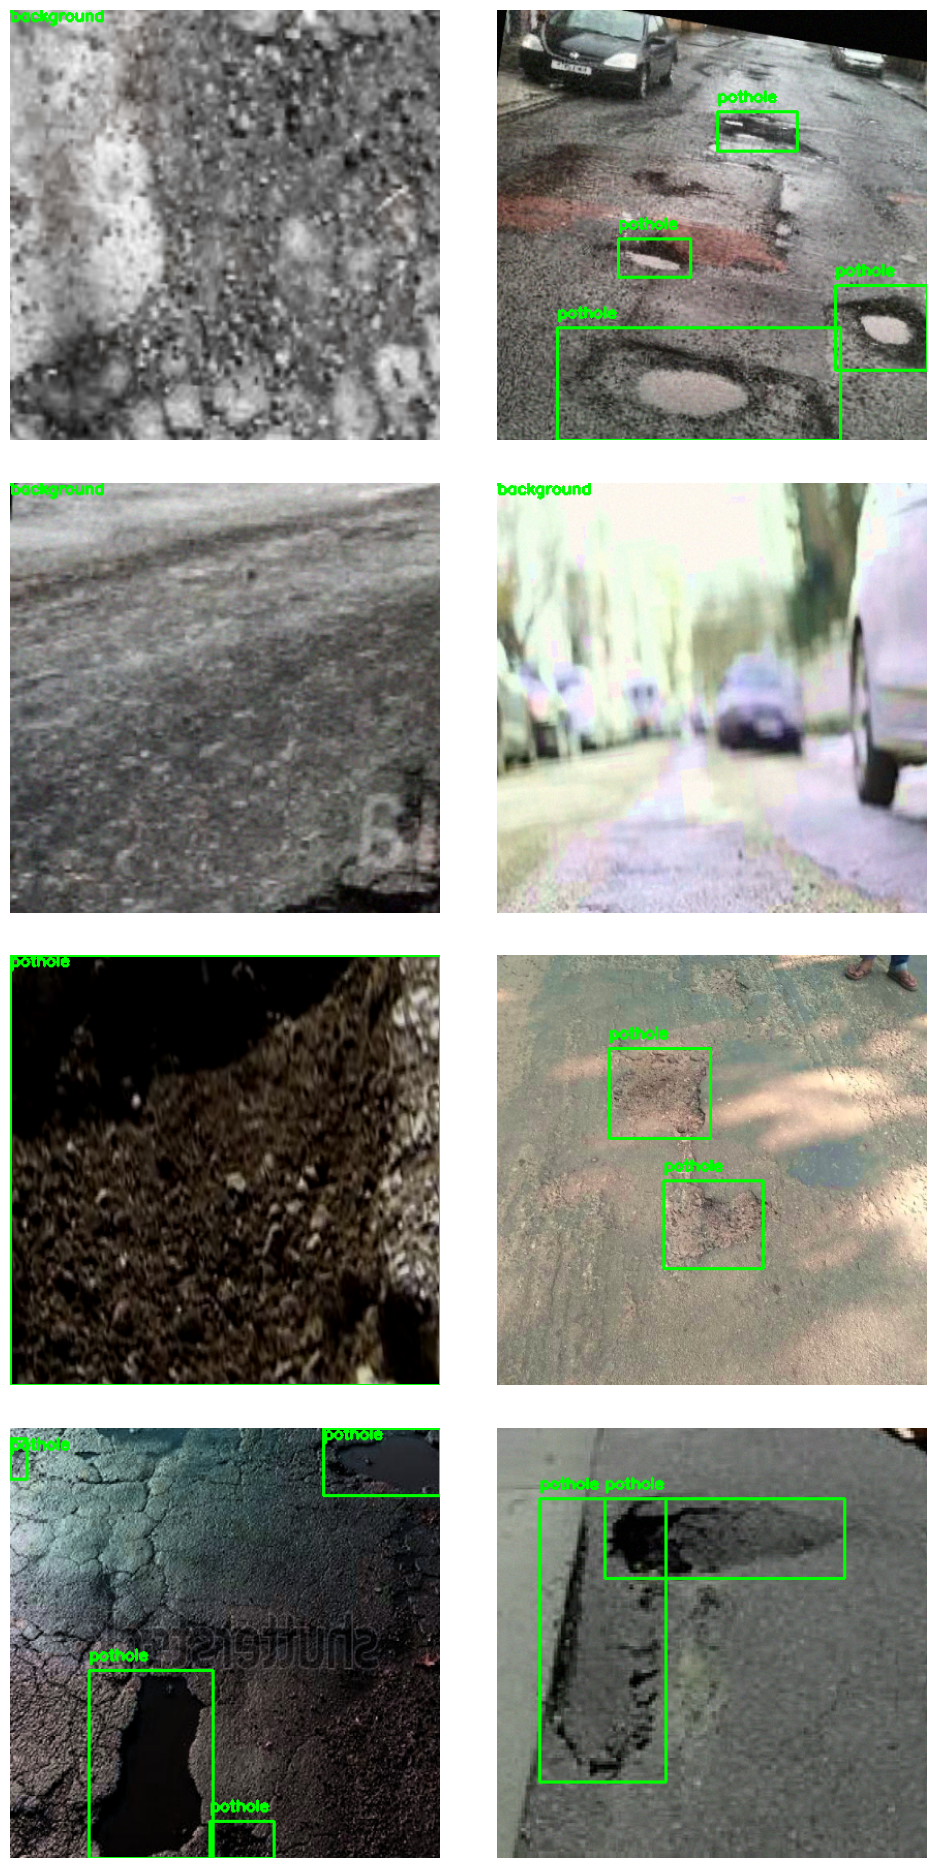

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

In [ ]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 156MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
model = model.to('cuda')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
def preprocess_bbox(prediction):

    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [ ]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0

    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()

    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")



RuntimeError: ignored

In [ ]:
model_weights_pth="/input/pothole/model (1).pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:06<00:00, 88.9MB/s]


FileNotFoundError: ignored

In [ ]:
def preprocess_bbox(prediction):

    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [ ]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        imgs = [img.float() for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

RuntimeError: ignored

In [ ]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

NameError: ignored

RuntimeError: ignored

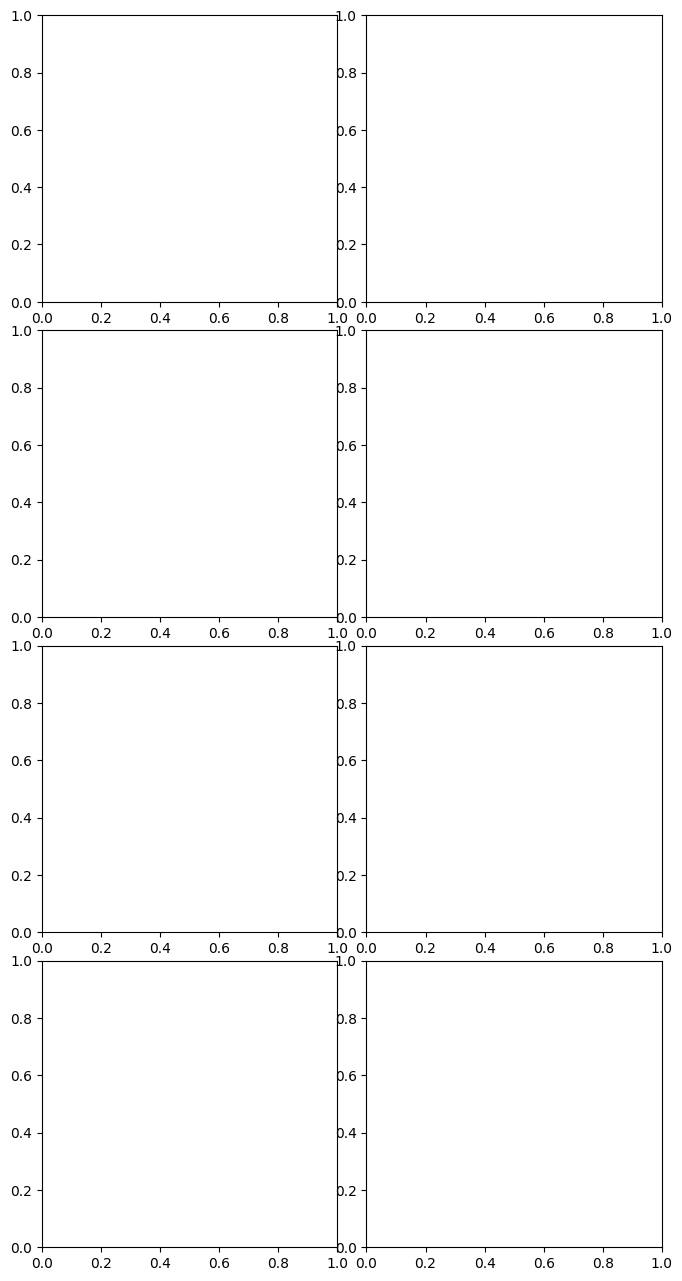

In [ ]:

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");

    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");

plt.savefig("4.png")
